In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
det_class_path = '../rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'
bbox_path = "../rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
dicom_dir = "../rsna-pneumonia-detection-challenge/stage_2_train_images"

### Class Info

30227 class infos loaded
26684 patient cases


,patientId,class
20179,b99dd9a2-7611-4752-a972-11a231a1deaf,Lung Opacity
18851,b0bd53e4-3e11-4583-8021-13d1ad1319b1,No Lung Opacity / Not Normal
16941,a2fe6d6d-3cf0-4fdd-b292-9d4b8553d4b7,Normal


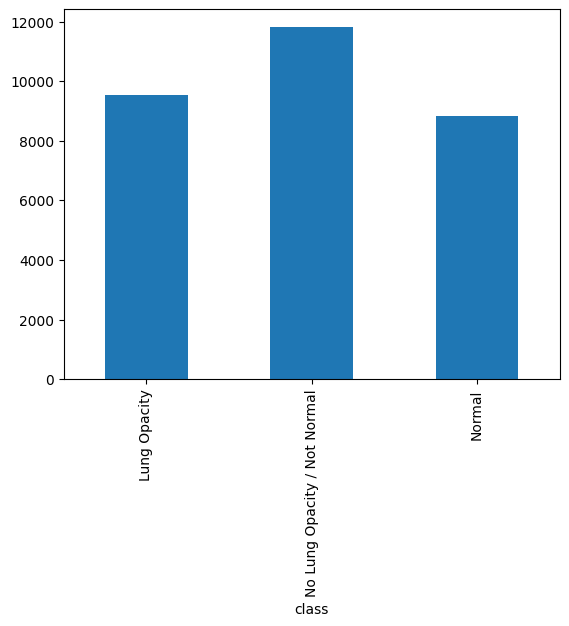

In [2]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

### Bounding Box Data

In [3]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
26393,eb91e5d2-e41f-433f-afd4-61429951efc4,NaN,NaN,NaN,NaN,0
15980,9b215f1b-5061-457f-acad-471ca01f774c,583.0,392.0,306.0,316.0,1
5215,45128bfb-0967-46b2-a4b8-23ba3f4f247b,260.0,493.0,165.0,155.0,1


### Combining the boxes and labels

In [17]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
14894,926c66da-c4a7-4df5-8377-771d5aa487e3,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3934,3ba4f6d7-e386-444e-8e99-6ae2e9f06888,NaN,NaN,NaN,NaN,0,Normal
21370,c2c1e0ab-281a-414c-9569-06b9408b50ff,NaN,NaN,NaN,NaN,0,Normal


### Box Distribution AMong Patients

In [21]:
box_df = comb_bbox_df.groupby('patientId').size().reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


### Class --- Target

In [22]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


### Parsing through the image files

In [29]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())

# To make sure that the image patient IDs and box patient IDs are the same
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

26684 images found


### Image Metadata 

In [31]:
image_bbox_df = pd.merge(comb_box_df,image_df,on='patientId',how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../rsna-pneumonia-detection-challenge/stage_2_...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../rsna-pneumonia-detection-challenge/stage_2_...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../rsna-pneumonia-detection-challenge/stage_2_...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../rsna-pneumonia-detection-challenge/stage_2_...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../rsna-pneumonia-detection-challenge/stage_2_...


### Extract more data from the DICOM header

,BodyPartExamined,ViewPosition,PatientSex
count,26684,26684,26684
unique,1,2,2
top,CHEST,PA,M
freq,26684,14511,15166


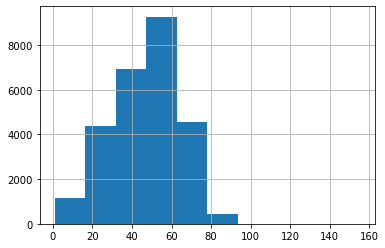

In [32]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)

image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [33]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_full_df.head(3)

,path,patientId,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,../rsna-pneumonia-detection-challenge/stage_2_...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,CHEST,PA,F
1,../rsna-pneumonia-detection-challenge/stage_2_...,000924cf-0f8d-42bd-9158-1af53881a557,19,CHEST,AP,F
2,../rsna-pneumonia-detection-challenge/stage_2_...,000db696-cf54-4385-b10b-6b16fbb3f985,25,CHEST,AP,F


### Sample Data

In [34]:
sample_df = image_bbox_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,f57a3824-8b1f-451a-a3b0-48beb8058057,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../rsna-pneumonia-detection-challenge/stage_2_...
1,71a17ca6-5e02-41af-9768-6b70349ddd1b,NaN,NaN,NaN,NaN,0,Normal,1,../rsna-pneumonia-detection-challenge/stage_2_...
2,74321b39-3aab-444a-893e-fa743ddc9224,500.0,544.0,193.0,128.0,1,Lung Opacity,1,../rsna-pneumonia-detection-challenge/stage_2_...
3,580536eb-6002-49c0-ac65-d330e36794b9,204.0,466.0,227.0,338.0,1,Lung Opacity,2,../rsna-pneumonia-detection-challenge/stage_2_...
4,580536eb-6002-49c0-ac65-d330e36794b9,557.0,374.0,265.0,434.0,1,Lung Opacity,2,../rsna-pneumonia-detection-challenge/stage_2_...
5,73dec8bd-601a-4cbe-9ae8-336c5cbd77e2,564.0,349.0,168.0,235.0,1,Lung Opacity,3,../rsna-pneumonia-detection-challenge/stage_2_...
6,73dec8bd-601a-4cbe-9ae8-336c5cbd77e2,578.0,602.0,197.0,260.0,1,Lung Opacity,3,../rsna-pneumonia-detection-challenge/stage_2_...
7,73dec8bd-601a-4cbe-9ae8-336c5cbd77e2,102.0,272.0,239.0,550.0,1,Lung Opacity,3,../rsna-pneumonia-detection-challenge/stage_2_...
8,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,322.0,327.0,116.0,119.0,1,Lung Opacity,4,../rsna-pneumonia-detection-challenge/stage_2_...
9,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,340.0,564.0,108.0,137.0,1,Lung Opacity,4,../rsna-pneumonia-detection-challenge/stage_2_...


### Box Position and Binding

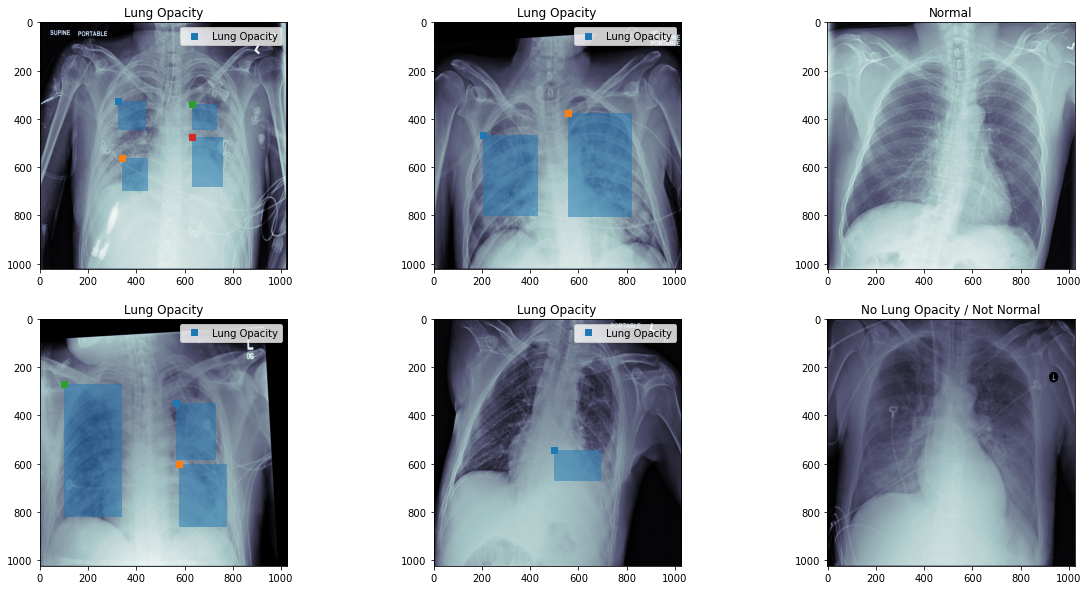

In [35]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

### Bounding box distribution

<AxesSubplot:xlabel='x', ylabel='y'>

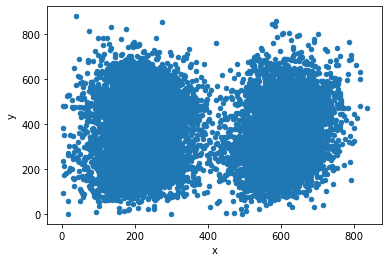

In [36]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

### Showing the box as segmentation

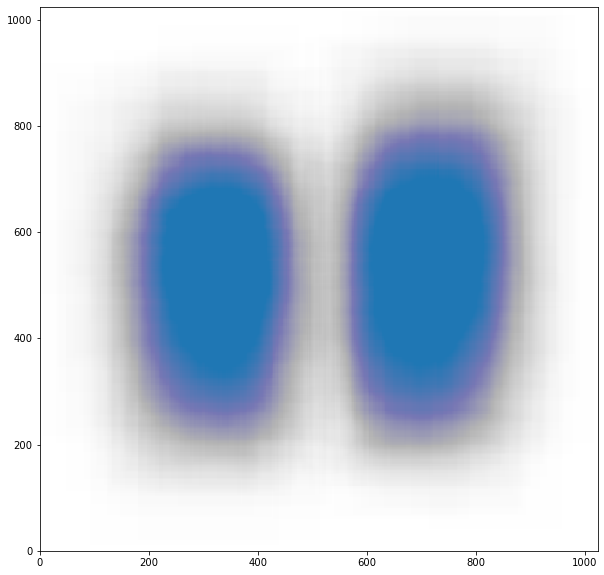

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

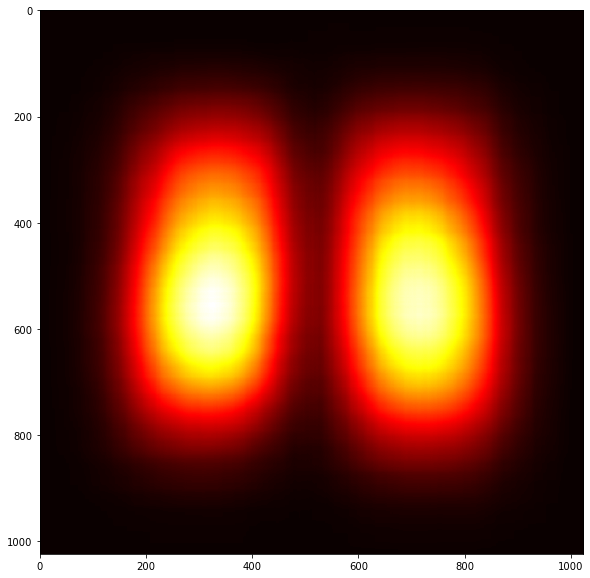

In [38]:
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

### Overlaying the probability on images

<ipython-input-39-6e3493b9f107>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figdpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('overview.png', figdpi = 600)


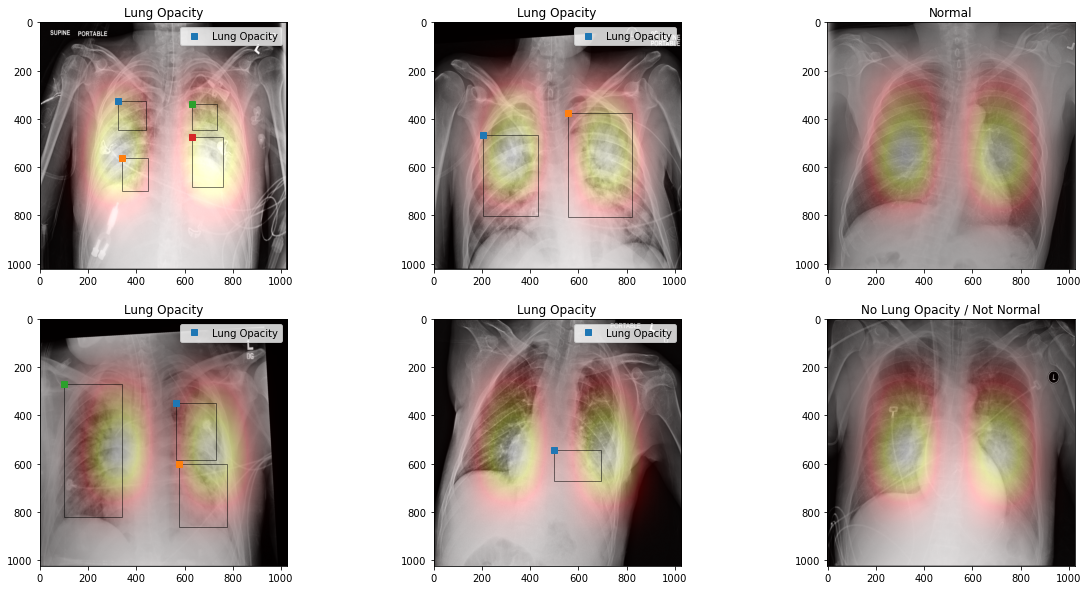

In [39]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

In [41]:
image_bbox_df.to_csv(r'C:\Users\U1138371\Documents\Capstone Project\Code\scott_mader.csv', index=False)